In [1]:
import random
import pathlib
import cytoolz
import numpy
from keras.models import Sequential, model_from_json
from keras.layers import LSTM, Dense, Embedding, Bidirectional
from keras.layers import TimeDistributed
from keras.optimizers import Adam
import thinc.extra.datasets
from spacy.compat import pickle
import spacy
import pandas as pd
from sklearn import preprocessing
import keras
from sklearn import model_selection
import seaborn as sns

Using TensorFlow backend.


## load in SRA data

In [2]:
inS_dir='/cellar/users/btsui/Data/nrnb01_nobackup/METAMAP/allSRS.pickle'

sra_dump_pickle_dir='/cellar/users/btsui/Data/SRA/DUMP/sra_dump.pickle'

srsS=pd.read_pickle(inS_dir)

technical_meta_data_df=pd.read_pickle(sra_dump_pickle_dir)

tmpDf=technical_meta_data_df.drop_duplicates('Sample')

technical_meta_data_df=tmpDf.sample(n=tmpDf.shape[0],random_state=0)

# load in spacy models

In [3]:
%%time
nlp=spacy.load('en_vectors_web_lg')

CPU times: user 12.1 s, sys: 992 ms, total: 13.1 s
Wall time: 13.1 s


    ## TimeDistributed: wrapper applies a layer to every temporal slice of an input.
    ## dense/ fully connected: a NN layer
    ## dense, nr_hidden, reduce the number of units
    ## 
    
    
        #lr: learning rate, binary_crossentropy


In [4]:
def compile_lstm(embeddings, shape, settings):
    model = Sequential()
    model.add(
        Embedding(
            embeddings.shape[0],
            embeddings.shape[1],
            input_length=shape['max_length'],
            trainable=False,
            weights=[embeddings],
            mask_zero=True
        )
    )
    model.add(TimeDistributed(Dense(shape['nr_hidden'], use_bias=False)))
    model.add(Bidirectional(LSTM(shape['nr_hidden'],
                                 recurrent_dropout=settings['dropout'],
                                 dropout=settings['dropout'])))
    model.add(Dense(shape['nr_class'], activation='sigmoid'))
    model.compile(optimizer=Adam(lr=settings['lr']), loss='binary_crossentropy',
		  metrics=['accuracy'])
    return model

def get_features(docs, max_length):
    docs = list(docs)
    Xs = numpy.zeros((len(docs), max_length), dtype='int32')
    for i, doc in enumerate(docs):
        j = 0
        for token in doc:
            ##rever to word vector
            vector_id = token.vocab.vectors.find(key=token.orth)
            if vector_id >= 0:
                Xs[i, j] = vector_id
            else:
                Xs[i, j] = 0
            j += 1
            if j >= max_length:
                break
    return Xs

In [5]:
max_length=10

### subset sra data

In [59]:

n=5000
subsampledSrs=technical_meta_data_df.groupby('Study').head(n=n)['Sample']

myAttribs=['cell type','sex','age','genotype','treatment','SCIENTIFIC_NAME']
m=srsS.index.get_level_values(0).isin(subsampledSrs.values)
m1=srsS.index.get_level_values(1).isin(myAttribs)
srsS_subS=srsS[m&m1]

In [60]:
le = preprocessing.LabelEncoder()
le.fit(myAttribs)
myDf=srsS_subS.reset_index()
myDf.columns=['srs','attrib','sentence']

In [61]:
inTrainTestDf=myDf.sample(n=myDf.shape[0]).groupby('attrib').head(n=20000)

train_df,test_df=model_selection.train_test_split(inTrainTestDf)

params

In [62]:
model_dir=None
train_dir=None
dev_dir=None
is_runtime=False
nr_hidden=64
max_length=50#, # Shape
dropout=0.5
learn_rate=0.001#, # General NN config
nb_epoch=1#
batch_size=100
nr_examples=-1  # Training params

In [63]:
nr_classes=len(le.classes_)

In [64]:
lstm_shape={'nr_hidden': 64, 'max_length': max_length, 'nr_class': nr_classes}
lstm_settings={'dropout': 0.5, 'lr': 0.001}


In [65]:
embeddings = nlp.vocab.vectors.data
#embedgigs is vocab.vectors.data
model = compile_lstm(embeddings, lstm_shape, lstm_settings)

In [66]:
train_texts=train_df.sentence.tolist()
dev_texts=test_df.sentence.tolist()

In [67]:
train_labels=keras.utils.to_categorical(
    le.transform(train_df.attrib.values))
dev_labels=keras.utils.to_categorical(le.transform(test_df.attrib.values))

In [68]:
by_sentence=False

In [69]:

print ('model:',model)
print("Parsing texts...")
train_docs = list(nlp.pipe(train_texts))
dev_docs = list(nlp.pipe(dev_texts))
#if by_sentence:
#    train_docs, train_labels = get_labelled_sentences(train_docs, train_labels)
#    dev_docs, dev_labels = get_labelled_sentences(dev_docs, dev_labels)

train_X = get_features(train_docs, lstm_shape['max_length'])
dev_X = get_features(dev_docs, lstm_shape['max_length'])
lstm=model.fit(train_X, train_labels, validation_data=(dev_X, dev_labels),
          nb_epoch=nb_epoch, batch_size=batch_size)


model: <keras.engine.sequential.Sequential object at 0x2aff900677f0>
Parsing texts...


/cellar/users/btsui/Data/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  del sys.path[0]


Train on 90000 samples, validate on 30000 samples
Epoch 1/1
90000/90000 [==============================] - 91s 1ms/step - loss: 0.1748 - acc: 0.9408 - val_loss: 0.1309 - val_acc: 0.9547


In [70]:
#lstm.model.predict()

In [71]:
#lstm. #dev_X

In [72]:

#s=['Homo sapiens','','5 year old','sapein 5']
val_docs = list(nlp.pipe(dev_texts))
val_X=get_features(val_docs,lstm_shape['max_length'])
predictM=lstm.model.predict_proba(val_X)
#tmpDf=pd.DataFrame(data=,columns=le.classes_,index=s)

In [73]:

tmpDf=pd.DataFrame(data=predictM,columns=le.classes_)

In [74]:
tmpDf.index=pd.MultiIndex.from_arrays([test_df.attrib.values,dev_texts],names=['entity','text'])

In [75]:
le.classes_

array(['SCIENTIFIC_NAME', 'age', 'cell type', 'genotype', 'sex',
       'treatment'], dtype='<U15')

In [76]:
probaDf=tmpDf.reset_index()

In [77]:
from sklearn import metrics

In [78]:
import matplotlib.pyplot as plt

In [79]:
#"{myClass} \n AUC: {AUC}".format(myClass=myClass,AUC=metrics.auc(fpr,tpr))

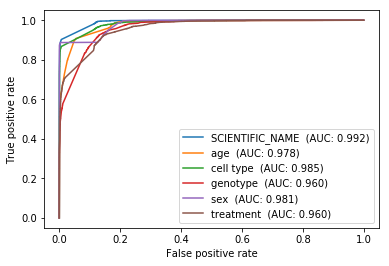

In [80]:
fig,ax=plt.subplots()
for myClass in le.classes_: 
    
    fpr,tpr,_=metrics.roc_curve((probaDf.entity==myClass),probaDf[myClass])
    
    #ax.set_label()
    
    ax.plot(fpr,tpr,label="{myClass}  (AUC: {AUC})".format(myClass=myClass,AUC=str(metrics.auc(fpr,tpr))[:5]))
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.legend()

### for a sentence split

In [81]:
"""
#s=['Homo sapiens','','5 year old','sapein 5']
val_docs = list(nlp.pipe(s))
val_X=get_features(val_docs,lstm_shape['max_length'])

tmpDf=pd.DataFrame(data=lstm.model.predict_proba(val_X),columns=le.classes_,index=s)

tmpDf"""

"\n#s=['Homo sapiens','','5 year old','sapein 5']\nval_docs = list(nlp.pipe(s))\nval_X=get_features(val_docs,lstm_shape['max_length'])\n\ntmpDf=pd.DataFrame(data=lstm.model.predict_proba(val_X),columns=le.classes_,index=s)\n\ntmpDf"

In [82]:
### use the a one 

In [83]:
#!pip install nltk

In [84]:
import nltk
from nltk.util import ngrams


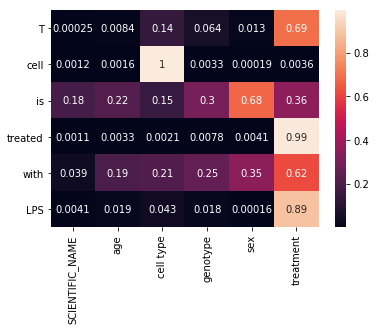

In [95]:
sent="T cell is treated with LPS"
s=sent.split(' ')
#def find_ngrams(input_list, n):
#    return zip(*[input_list[i:] for i in range(n)])
val_docs = list(nlp.pipe(s))
val_X=get_features(val_docs,lstm_shape['max_length'])

tmpDf=pd.DataFrame(data=lstm.model.predict_proba(val_X),columns=le.classes_,index=s)
sns.heatmap(tmpDf,annot=True)

['T', 'cell', 'is', 'treated', 'with', 'LPS']


Text(0.5,1,'1 grams')

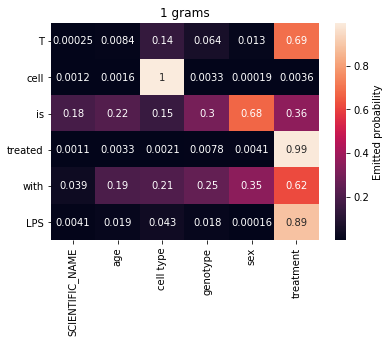

In [98]:
n_gram=1
grams=list(map(lambda L:" ".join(L),list(ngrams(s,n_gram))))
print (grams)
val_docs = list(nlp.pipe(grams))
val_X=get_features(val_docs,lstm_shape['max_length'])

tmpDf=pd.DataFrame(data=lstm.model.predict_proba(val_X),columns=le.classes_,index=grams)
ax=sns.heatmap(tmpDf,cbar_kws={'label': 'Emitted probability'},annot=True)
ax.set_ylabel('')
ax.set_title('{} grams'.format(n_gram))

In [90]:
val_X=get_features(val_docs,lstm_shape['max_length'])

In [ ]:
!echo $PWD/Data/DEEP_NLP/NLP_spacy/keras_on_sra_data_v2.ipynb

In [ ]:
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot

#SVG(model_to_dot(lstm.model).create(prog='dot', format='svg'))

In [ ]:
#!pip install pydot

In [ ]:
#from keras.utils import plot_model
#plot_model(model, to_file='model.png')
